In [199]:
!pip install fyers-apiv3 numpy pandas scipy

import datetime
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
from fyers_apiv3 import fyersModel
import time
import datetime
from fyers_apiv3 import fyersModel


In [ ]:
from google.colab import files
uploaded = files.upload()
!python /content/login.py
import os
print(os.listdir("/content/"))

In [201]:
with open("fyers_token.txt", "r") as file:
    access_token = file.read().strip()

client_id = "XXXXXXXXX-XXX"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token, log_path="")


In [202]:

def fetch_fyers_data(symbol, resolution="1", date_format="1"):
    data = {
        "symbol": symbol,
        "resolution": resolution,
        "date_format": date_format,
        "range_from": "2024-11-13",
        "range_to": "2025-02-13",
        "cont_flag": "1"
    }

    response = fyers.history(data=data)
    if "candles" in response:
        df = pd.DataFrame(response["candles"], columns=["timestamp", "open", "high", "low", "close", "volume"])
        df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
        df["datetime"] = df["datetime"] + datetime.timedelta(hours=5, minutes=30)

        return df
    else:
        print(f"Error fetching data for {symbol}: {response}")
        return None

nifty_spot_df = fetch_fyers_data("NSE:NIFTY50-INDEX")
nifty_spot_df




,timestamp,open,high,low,close,volume,datetime
0,1731469500,23822.45,23841.40,23780.30,23838.85,0,2024-11-13 09:15:00
1,1731469560,23840.05,23848.05,23821.25,23830.35,0,2024-11-13 09:16:00
2,1731469620,23830.75,23851.95,23822.70,23832.55,0,2024-11-13 09:17:00
3,1731469680,23830.40,23850.20,23830.10,23849.15,0,2024-11-13 09:18:00
4,1731469740,23848.15,23862.55,23831.75,23831.75,0,2024-11-13 09:19:00
...,...,...,...,...,...,...,...
24370,1739440500,23023.60,23028.10,23023.60,23025.90,0,2025-02-13 15:25:00
24371,1739440560,23025.65,23026.30,23021.50,23022.80,0,2025-02-13 15:26:00
24372,1739440620,23022.55,23024.45,23021.05,23022.00,0,2025-02-13 15:27:00
24373,1739440680,23019.75,23023.85,23017.80,23020.75,0,2025-02-13 15:28:00


In [203]:
trade_dates = nifty_spot_df["datetime"].dt.date.unique()
print(trade_dates)

[datetime.date(2024, 11, 13) datetime.date(2024, 11, 14)
 datetime.date(2024, 11, 18) datetime.date(2024, 11, 19)
 datetime.date(2024, 11, 21) datetime.date(2024, 11, 22)
 datetime.date(2024, 11, 25) datetime.date(2024, 11, 26)
 datetime.date(2024, 11, 27) datetime.date(2024, 11, 28)
 datetime.date(2024, 11, 29) datetime.date(2024, 12, 2)
 datetime.date(2024, 12, 3) datetime.date(2024, 12, 4)
 datetime.date(2024, 12, 5) datetime.date(2024, 12, 6)
 datetime.date(2024, 12, 9) datetime.date(2024, 12, 10)
 datetime.date(2024, 12, 11) datetime.date(2024, 12, 12)
 datetime.date(2024, 12, 13) datetime.date(2024, 12, 16)
 datetime.date(2024, 12, 17) datetime.date(2024, 12, 18)
 datetime.date(2024, 12, 19) datetime.date(2024, 12, 20)
 datetime.date(2024, 12, 23) datetime.date(2024, 12, 24)
 datetime.date(2024, 12, 26) datetime.date(2024, 12, 27)
 datetime.date(2024, 12, 30) datetime.date(2024, 12, 31)
 datetime.date(2025, 1, 1) datetime.date(2025, 1, 2)
 datetime.date(2025, 1, 3) datetime.date(

In [204]:
if nifty_spot_df is None or nifty_spot_df.empty:
    print("Error: Could not fetch NIFTY50 index data from Fyers API.")
    exit()

nifty_options_list = []

def get_expiry_date(given_date):
    days_until_thursday = (3 - given_date.weekday() + 7) % 7
    next_thursday = given_date + datetime.timedelta(days=days_until_thursday)

    last_day_of_month = (given_date.replace(day=28) + datetime.timedelta(days=4)).replace(day=1) - datetime.timedelta(days=1)
    days_to_last_thursday = (last_day_of_month.weekday() - 3) % 7
    last_thursday = last_day_of_month - datetime.timedelta(days=days_to_last_thursday)

    if next_thursday >= last_thursday:
        expiry_str = f"{str(last_thursday.year)[-2:]}{last_thursday.strftime('%b').upper()}"
    else:
        expiry_str = f"{str(next_thursday.year)[-2:]}{next_thursday.month}{next_thursday.day:02}"

    return expiry_str

for trade_date in trade_dates:
    print(f"Processing trade date: {trade_date}")

    spot_price_data = nifty_spot_df[
        (nifty_spot_df['datetime'].dt.date == trade_date) &
        (nifty_spot_df['datetime'].dt.time.between(datetime.time(9, 19), datetime.time(9, 21)))
    ]

    if spot_price_data.empty:
        print(f"Skipping {trade_date}: No 9:20 AM data available.")
        continue

    spot_price_9_20 = spot_price_data['close'].values[0]
    atm_strike_price = round(spot_price_9_20 / 100) * 100
    expiry_str = get_expiry_date(trade_date)

    ce_symbol_nifty = f"NSE:NIFTY{expiry_str}{atm_strike_price}CE"
    pe_symbol_nifty = f"NSE:NIFTY{expiry_str}{atm_strike_price}PE"

    print(f"Fetching CE: {ce_symbol_nifty}, PE: {pe_symbol_nifty}")

    ce_df = fetch_fyers_data(ce_symbol_nifty)
    pe_df = fetch_fyers_data(pe_symbol_nifty)

    if ce_df is None or ce_df.empty or pe_df is None or pe_df.empty:
        print(f"Skipping {trade_date}: Option data not available.")
        continue

    ce_price_data = ce_df[
        (ce_df['datetime'].dt.date == trade_date) &
        (ce_df['datetime'].dt.time.between(datetime.time(9, 19), datetime.time(9, 21)))
    ]
    pe_price_data = pe_df[
        (pe_df['datetime'].dt.date == trade_date) &
        (pe_df['datetime'].dt.time.between(datetime.time(9, 19), datetime.time(9, 21)))
    ]

    if ce_price_data.empty or pe_price_data.empty:
        print(f"Skipping {trade_date}: No 9:20 AM option prices available.")
        continue

    ce_price_9_20 = ce_price_data['close'].values[0]
    pe_price_9_20 = pe_price_data['close'].values[0]

    spot_price_data2 = nifty_spot_df[
        (nifty_spot_df['datetime'].dt.date == trade_date) &
        (nifty_spot_df['datetime'].dt.time.between(datetime.time(15, 24), datetime.time(15, 26)))
    ]


    spot_price_3_25 = spot_price_data2['close'].values[0]
    atm_strike_price2 = atm_strike_price
    expiry_str2 = get_expiry_date(trade_date)

    ce_symbol_nifty2 = f"NSE:NIFTY{expiry_str2}{atm_strike_price2}CE"
    pe_symbol_nifty2 = f"NSE:NIFTY{expiry_str2}{atm_strike_price2}PE"

    ce_df2 = fetch_fyers_data(ce_symbol_nifty2)
    pe_df2 = fetch_fyers_data(pe_symbol_nifty2)

    ce_price_data2 = ce_df2[
        (ce_df2['datetime'].dt.date == trade_date) &
        (ce_df2['datetime'].dt.time.between(datetime.time(15, 24), datetime.time(15, 26)))
    ]
    pe_price_data2 = pe_df2[
        (pe_df2['datetime'].dt.date == trade_date) &
        (pe_df2['datetime'].dt.time.between(datetime.time(15, 24), datetime.time(15, 26)))
    ]


    if not ce_price_data2.empty:
        ce_price_3_25 = ce_price_data2['close'].values[0]
    else:
        ce_price_3_25 = None

    if not pe_price_data2.empty:
        pe_price_3_25 = pe_price_data2['close'].values[0]
    else:
        pe_price_3_25 = None

    nifty_options_list.append({
        "Trade Date": trade_date,
        "Spot Price": spot_price_9_20,
        "ATM Strike": atm_strike_price,
        "Call Option": ce_symbol_nifty,
        "Put Option": pe_symbol_nifty,
        "Call Price": ce_price_9_20,
        "Put Price": pe_price_9_20,
        "Call Price 3:25": ce_price_3_25,
        "Put Price 3:25":  pe_price_3_25
    })

nifty_options_df = pd.DataFrame(nifty_options_list)
print("Final Options DataFrame:\n", nifty_options_df)

Processing trade date: 2024-11-13
Fetching CE: NSE:NIFTY24111423800CE, PE: NSE:NIFTY24111423800PE
Error fetching data for NSE:NIFTY24111423800CE: {'code': -300, 'message': 'Invalid symbol provided', 's': 'error'}
Error fetching data for NSE:NIFTY24111423800PE: {'code': -300, 'message': 'Invalid symbol provided', 's': 'error'}
Skipping 2024-11-13: Option data not available.
Processing trade date: 2024-11-14
Fetching CE: NSE:NIFTY24111423600CE, PE: NSE:NIFTY24111423600PE
Error fetching data for NSE:NIFTY24111423600CE: {'code': -300, 'message': 'Invalid symbol provided', 's': 'error'}
Error fetching data for NSE:NIFTY24111423600PE: {'code': -300, 'message': 'Invalid symbol provided', 's': 'error'}
Skipping 2024-11-14: Option data not available.
Processing trade date: 2024-11-18
Fetching CE: NSE:NIFTY24112123500CE, PE: NSE:NIFTY24112123500PE
Error fetching data for NSE:NIFTY24112123500CE: {'code': -300, 'message': 'Invalid symbol provided', 's': 'error'}
Error fetching data for NSE:NIFTY24

In [205]:
import numpy as np
import datetime
from scipy.stats import norm
import datetime

def get_expiry_date(given_date):

    # Find the next Thursday
    days_until_thursday = (3 - given_date.weekday() + 7) % 7
    next_thursday = given_date + datetime.timedelta(days=days_until_thursday)

    # Find the last Thursday
    last_day_of_month = (given_date.replace(day=28) + datetime.timedelta(days=4)).replace(day=1) - datetime.timedelta(days=1)
    days_to_last_thursday = (last_day_of_month.weekday() - 3) % 7
    last_thursday = last_day_of_month - datetime.timedelta(days=days_to_last_thursday)

    # Find the second-last Thursday
    second_last_thursday = last_thursday - datetime.timedelta(days=7)

    # Find the first Thursday of next month
    first_day_next_month = given_date.replace(day=1) + datetime.timedelta(days=32)
    first_day_next_month = first_day_next_month.replace(day=1)
    days_until_first_thursday = (3 - first_day_next_month.weekday() + 7) % 7
    first_thursday_next_month = first_day_next_month + datetime.timedelta(days=days_until_first_thursday)


    if second_last_thursday < given_date <= last_thursday:
        # Second last Thursday to last Thursday (inclusive) → 'YYMMM' format
        next_thursday = last_thursday
        expiry_str = f"{str(next_thursday.year)[-2:]}{next_thursday.strftime('%b').upper()}"

    else:
        # Normal weekly expiry in 'YYMDD' format
        expiry_str = f"{str(next_thursday.year)[-2:]}{next_thursday.month}{next_thursday.day:02}"

    return next_thursday, expiry_str


def calculate_time_to_expiry(trade_date):
    """
    Calculates time to expiry (T) in years.
    """
    expiry_date, _ = get_expiry_date(trade_date)
    time_to_expiry_days = (expiry_date - trade_date).days
    return time_to_expiry_days / 252  # Convert to years

def black_scholes(S, K, T, r, sigma, option_type="call"):
    if T <= 0:
        return max(S - K, 0) if option_type == "call" else max(K - S, 0)  # Avoid division by zero

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def binomial_tree(S, K, T, r, sigma, N=100, option_type='call'):
    deltaT = T / N
    u = np.exp(sigma * np.sqrt(deltaT))
    d = 1 / u
    p = (np.exp(r * deltaT) - d) / (u - d)

    option_values = np.maximum(0, (S * (u ** np.arange(N, -1, -1)) * (d ** np.arange(0, N + 1))) - K if option_type == "call" else K - (S * (u ** np.arange(N, -1, -1)) * (d ** np.arange(0, N + 1))))

    for n in range(N - 1, -1, -1):
        option_values = np.exp(-r * deltaT) * (p * option_values[:-1] + (1 - p) * option_values[1:])

    return option_values[0]

def monte_carlo(S, K, T, r, sigma, n_simulations=10000, option_type='call'):
    Z = np.random.standard_normal(n_simulations)
    ST = S * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z)
    payoff = np.maximum(ST - K, 0) if option_type == 'call' else np.maximum(K - ST, 0)
    return np.exp(-r * T) * np.mean(payoff)

for index, row in nifty_options_df.iterrows():
    S = row["Spot Price"]
    K = row["ATM Strike"]
    T = calculate_time_to_expiry(row["Trade Date"])
    T = T if T != 0 else 0.5 / 252
    r = 0.07

    expiry_date, expiry_str = get_expiry_date(row["Trade Date"])
    atm_strike_price = round(S / 100) * 100

    ce_symbol_nifty = f"NSE:NIFTY{expiry_str}{atm_strike_price}CE"
    pe_symbol_nifty = f"NSE:NIFTY{expiry_str}{atm_strike_price}PE"

    data_call = {"symbol": ce_symbol_nifty, "strikecount": 1, "timestamp": ""}
    data_put = {"symbol": pe_symbol_nifty, "strikecount": 1, "timestamp": ""}

    response_call = fyers.optionchain(data=data_call)
    response_put = fyers.optionchain(data=data_put)

    try:
        sigma_call = response_call["data"]["indiavixData"]["ltp"] / 100
        sigma_put = response_put["data"]["indiavixData"]["ltp"] / 100
    except KeyError:
        sigma_call = 0.15
        sigma_put = 0.15

    bs_call = black_scholes(S, K, float(T), r, sigma_call, "call")
    bs_put = black_scholes(S, K, float(T), r, sigma_put,"put")
    bt_call = binomial_tree(S, K, float(T), r, sigma_call,100, "call")
    bt_put = binomial_tree(S, K, float(T), r, sigma_put, 100,"put")
    mc_call = monte_carlo(S, K, float(T), r, sigma_call,10000, "call")
    mc_put = monte_carlo(S, K, float(T), r, sigma_put, 10000,"put")

    nifty_options_df.at[index, "BS_Call"] = bs_call
    nifty_options_df.at[index, "BS_Put"] = bs_put
    nifty_options_df.at[index, "BT_Call"] = bt_call
    nifty_options_df.at[index, "BT_Put"] = bt_put
    nifty_options_df.at[index, "MC_Call"] = mc_call
    nifty_options_df.at[index, "MC_Put"] = mc_put

nifty_options_df


,Trade Date,Spot Price,ATM Strike,Call Option,Put Option,Call Price,Put Price,Call Price 3:25,Put Price 3:25,BS_Call,BS_Put,BT_Call,BT_Put,MC_Call,MC_Put
0,2024-11-22,23420.65,23400,NSE:NIFTY24NOV23400CE,NSE:NIFTY24NOV23400PE,200.30,163.00,555.15,65.10,247.096527,187.479009,247.217023,187.599505,250.761896,193.414074
1,2024-11-25,24288.60,24300,NSE:NIFTY24NOV24300CE,NSE:NIFTY24NOV24300PE,176.25,173.45,130.25,141.75,163.015131,154.173566,163.007064,154.165499,163.449544,152.472918
2,2024-11-26,24310.35,24300,NSE:NIFTY24NOV24300CE,NSE:NIFTY24NOV24300PE,136.35,124.25,69.45,NaN,141.808439,117.962188,141.830019,117.983768,142.342598,117.221335
3,2024-12-20,23923.30,23900,NSE:NIFTY24DEC23900CE,NSE:NIFTY24DEC23900PE,227.40,181.90,82.15,340.90,253.589459,190.489301,253.764789,190.664632,253.359116,189.486997
4,2024-12-23,23769.55,23800,NSE:NIFTY24DEC23800CE,NSE:NIFTY24DEC23800PE,138.90,147.90,83.50,111.00,149.975112,160.600040,150.323517,160.948445,150.129957,160.761655
5,2024-12-24,23767.95,23800,NSE:NIFTY24DEC23800CE,NSE:NIFTY24DEC23800PE,67.20,95.40,52.40,77.70,117.565177,136.396626,117.879379,136.710829,116.381203,139.010466
6,2024-12-26,23835.40,23800,NSE:NIFTY24DEC23800CE,NSE:NIFTY24DEC23800PE,91.30,42.70,0.05,50.25,84.703997,45.998671,84.669082,45.963756,83.264009,45.379751
7,2025-01-01,23675.65,23700,NSE:NIFTY2510223700CE,NSE:NIFTY2510223700PE,105.50,131.80,176.50,77.95,80.679507,98.447087,80.897501,98.665082,80.525338,97.806384
8,2025-01-02,23788.85,23800,NSE:NIFTY2510223800CE,NSE:NIFTY2510223800PE,111.70,116.30,390.00,0.10,59.575456,67.420130,59.704933,67.549607,59.489556,66.806789
9,2025-01-03,24175.55,24200,NSE:NIFTY2510924200CE,NSE:NIFTY2510924200PE,166.40,198.80,78.15,281.05,231.166533,215.316792,231.366800,215.517059,233.074592,220.827359


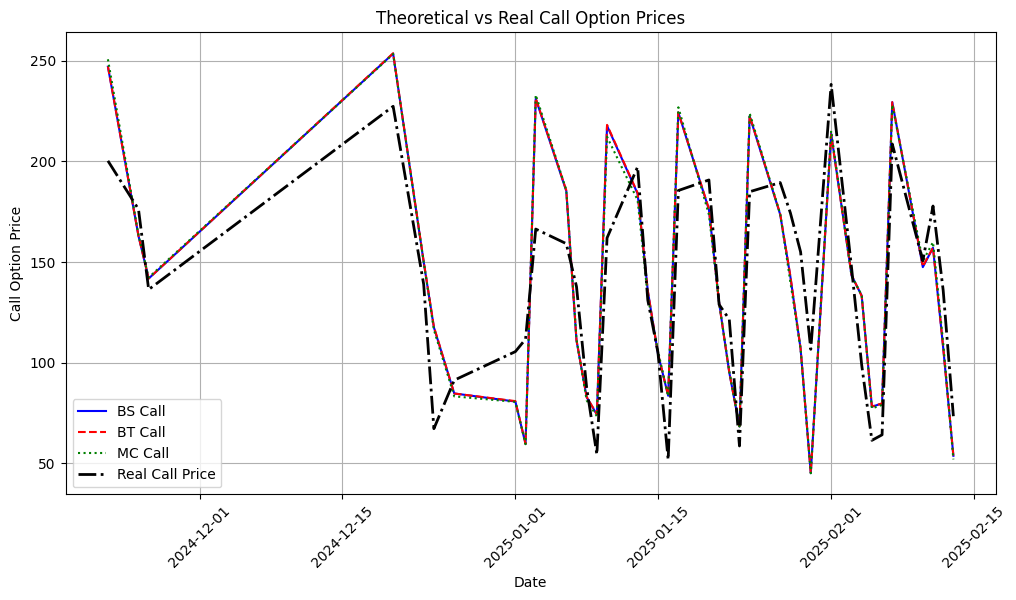

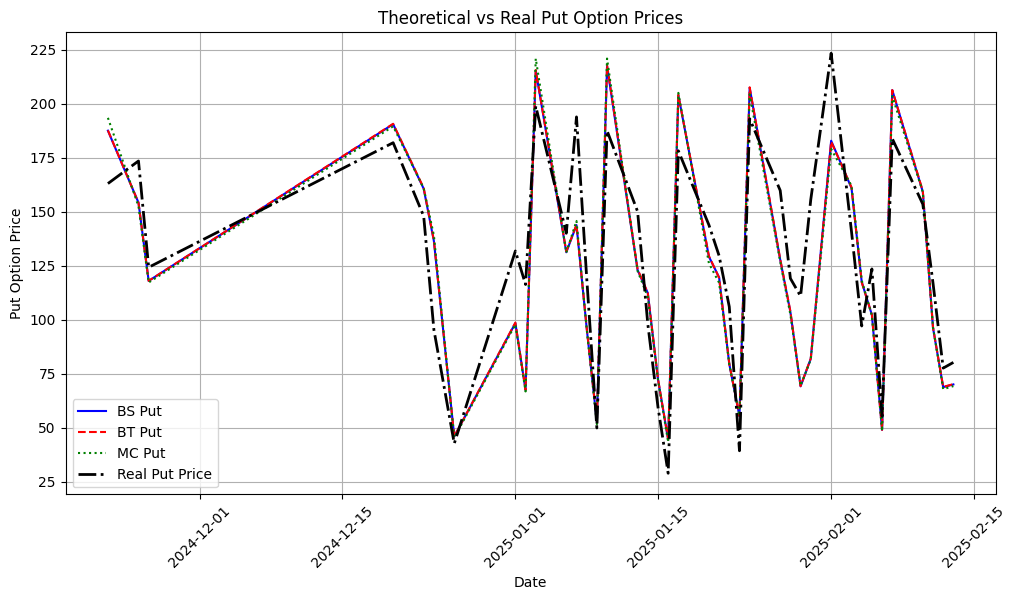

In [212]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame(nifty_options_df)


df["Trade Date"] = pd.to_datetime(df["Trade Date"])

plt.figure(figsize=(12, 6))
plt.plot(df["Trade Date"], df["BS_Call"], label="BS Call", color="blue", linestyle="-")
plt.plot(df["Trade Date"], df["BT_Call"], label="BT Call", color="red", linestyle="--")
plt.plot(df["Trade Date"], df["MC_Call"], label="MC Call", color="green", linestyle=":")
plt.plot(df["Trade Date"], df["Call Price"], label="Real Call Price", color="black", linestyle="-.", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Call Option Price")
plt.title("Theoretical vs Real Call Option Prices")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df["Trade Date"], df["BS_Put"], label="BS Put", color="blue", linestyle="-")
plt.plot(df["Trade Date"], df["BT_Put"], label="BT Put", color="red", linestyle="--")
plt.plot(df["Trade Date"], df["MC_Put"], label="MC Put", color="green", linestyle=":")
plt.plot(df["Trade Date"], df["Put Price"], label="Real Put Price", color="black", linestyle="-.", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Put Option Price")
plt.title("Theoretical vs Real Put Option Prices")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()
